<a href="https://colab.research.google.com/github/erlichsefi/ScrapeAnything/blob/main/browser_base_translation%20/%20JavaScript%20Converting%20Robust%20Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Converting sites to dataframe

# first: install selenium & chromium

In [1]:
# According to: https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com
%%capture
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium
apt install chromium-chromedriver
pip install pandas

In [24]:
script_with_logs = """
// Get all elements in the HTML page
const elements = document.getElementsByTagName('*');

// Create an array to store the element details
const elementDetails = [];

// Iterate through each element
for (let i = 0; i < elements.length; i++) {
  const element = elements[i];

  // Get the bounding rectangle of the element
  const rect = element.getBoundingClientRect();

  // Get the text content of the element
  const textContent = element.textContent.trim();

  // Get the tooltip value if it exists
  const tooltip = element.hasAttribute('title') ? element.getAttribute('title') : '';

  // Get the aria-label value
  const ariaLabel = (element.hasAttribute('aria-label') ? element.getAttribute('aria-label') : '');

  // Get the nodeName
  const e_type = element.nodeName;

  // Get the data-initial-value
  const data_initial_value = (element.hasAttribute('data-initial-value') ? element.getAttribute('data-initial-value') : '')

  // Get innerText
  const innerText = element.innerText

  // Store the element, its bounding rectangle, text content, and tooltip details
  const elementInfo = {
    element: element,
    rect: rect,
    textContent: textContent.replaceAll(",",";"),
    ariaLabel: ariaLabel.replaceAll(",",";"),
    tooltip: tooltip.replaceAll(",",";"),
    e_type: e_type.replaceAll(",",";"),
    data_initial_value: data_initial_value.replaceAll(",",";"),
    innerText: innerText !== undefined ? innerText.replaceAll(",",";"): "",
  };

//  const viewpointscroll = window.pageYOffset || document.documentElement.scrollTop;
//  const viewportHeight = window.innerheight || document.documentElement.clientHeight;
//  && elementInfo.rect.bottom > viewpointscroll && elementInfo.rect.top < (viewpointscroll-viewportHeight)
  if ( elementInfo.rect.width > 0 && elementInfo.rect.height > 0){
    if (elementInfo.innerText != '' || elementInfo.data_initial_value != '' || elementInfo.tooltip != '' || elementInfo.textContent != '' || elementInfo.ariaLabel != ''){
      elementDetails.push(elementInfo);
    }

  }
}

let parents = elementDetails.map(e => e.element.parentElement);
let withoutParents = elementDetails.filter(elementDetail => !( parents.includes(elementDetail.element)));

// Display the element details
console.log("X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value");
console.log(withoutParents.map( e=> e.rect.x+","+e.rect.y+","+e.rect.top+","+e.rect.bottom+","+e.rect.left+","+e.rect.right+","+e.rect.width+","+e.rect.height+","+e.e_type+","+e.textContent+","+e.tooltip+","+e.ariaLabel+","+e.data_initial_value).join("\\n"));
"""

In [25]:
def write_to_text(filename,logs,error):
  with open(filename, 'w') as f:
    f.write(f"error={error}\n")
    f.write('\n'.join(logs))

def draw_all_rec_on_screenshot(file_name,list_of_elements):
  from PIL import Image, ImageDraw
  # Load the screenshot image
  screenshot = Image.open(file_name)
  # Create a drawing object
  draw = ImageDraw.Draw(screenshot)

  for _,elements in list_of_elements.iterrows():
    #print(elements)
    # x = elements['X']
    # y = elements['X']
    top = elements['Top']
    bottom = elements['Bottom']
    left = elements['Left']
    right = elements['Right']
    # width = elements['Width']
    # height = elements['Height']

    # Draw a rectangle on the screenshot image
    draw.rectangle([(left, top), (right, bottom)], outline='red')

    # Save the modified screenshot with the drawn rectangle
  screenshot.save(f"boxes_{file_name}")

In [26]:
def web_driver_to_image(wd,prefix=""):
  import re
  import os
  from urllib.parse import urlparse, urlunparse

  url = wd.current_url
  # Parse the URL
  parsed_url = urlparse(url)

  # Remove the query parameters
  clean_url = urlunparse((parsed_url.scheme, parsed_url.netloc, parsed_url.path, "", "", ""))
  file_name = re.sub(r'[^a-zA-Z0-9_-]', '_', clean_url)
  file_name = f"{prefix}{file_name}"

  wd.save_screenshot(f"{file_name}.png")
  return file_name

def get_browser():
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service

    # restart the browser
    service = Service(executable_path=r'/usr/bin/chromedriver')
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless=new')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.headless = True
    wd = webdriver.Chrome(service=service,options=chrome_options)

    return wd

def screen_to_table(wd,url,raw=False):

  import pandas as pd
  import io

  for timeout in range(10,60,20):
    try:
      wd.set_page_load_timeout(timeout)
      wd.implicitly_wait(timeout)  # Set a timeout of 10 seconds
      wd.get(url)
      break

    except Exception:
      pass

  file_name = web_driver_to_image(wd)

  script = f"""
  var consoleLogs = [];
  var originalLog = console.log;
  console.log = function(message) {{
      consoleLogs.push(message);
      originalLog.apply(console, arguments);
  }};

  {script_with_logs}

  return consoleLogs;
  """

  logs = wd.execute_script(script)

  if not raw:
    df = pd.read_csv(io.StringIO("\n".join(logs)), sep=",")
    draw_all_rec_on_screenshot(f"{file_name}.png",df)
  else:
    df = logs
  #wd.close()
  return file_name,df

In [27]:
wd = get_browser()
df = screen_to_table(wd,"https://www.bbc.com")

<ipython-input-26-e0cde5318047>:27: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  chrome_options.headless = True


In [29]:
df[1]

,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value


In [7]:
news_sites = [
    "https://www.n12.co.il/",
    "https://www.cnn.com",
    "https://www.bbc.co.uk/news",
    "https://www.nytimes.com",
    "https://www.aljazeera.com",
    "https://www.reuters.com",
    "https://www.theguardian.com",
    "https://www.foxnews.com",
    "https://www.nbcnews.com",
    "https://www.bloomberg.com",
    "https://apnews.com",
    "https://www.huffpost.com",
    "https://www.usatoday.com",
    "https://www.washingtonpost.com",
    "https://www.wsj.com",
    "https://abcnews.go.com",
    "https://www.buzzfeednews.com",
    "https://www.cbsnews.com",
    "https://www.npr.org",
    "https://www.ft.com",
    "https://www.independent.co.uk",
]

In [8]:
wd = get_browser()

for url in news_sites:
  print(f" ---- URL = {url} ---- ")

  try:
    file_name,df = screen_to_table(wd,url)
    csv_file_name = f"{file_name}.csv"
    screenshot_file_name = f"{file_name}.png"
    df.to_csv(csv_file_name)

    print(f"screenshot_file_name = {screenshot_file_name}.")
    print(f"Parsing was sucsessful, csv_file_name = {csv_file_name}.")
  except Exception as e:
    file_name,df = screen_to_table(wd,url,raw=True)
    txt_file_name = f"{file_name}.txt"
    write_to_text(txt_file_name,df,e)


    print(f"screenshot_file_name = {screenshot_file_name}.")
    print(f"Parsing was un-sucsessful, txt_file_name = {txt_file_name}.")

  print(f"please make sure all text in screenshot is explained by output file")

<ipython-input-5-e0cde5318047>:27: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  chrome_options.headless = True


 ---- URL = https://www.n12.co.il/ ---- 


KeyboardInterrupt: ignored

# Here is some issues found in manual analysis

In [ ]:
def describe(site):
  from IPython.display import Image, display
  display(Image(filename=f"boxes_{site}.png"))

  import pandas as pd
  return pd.read_csv(f"{site}.csv")

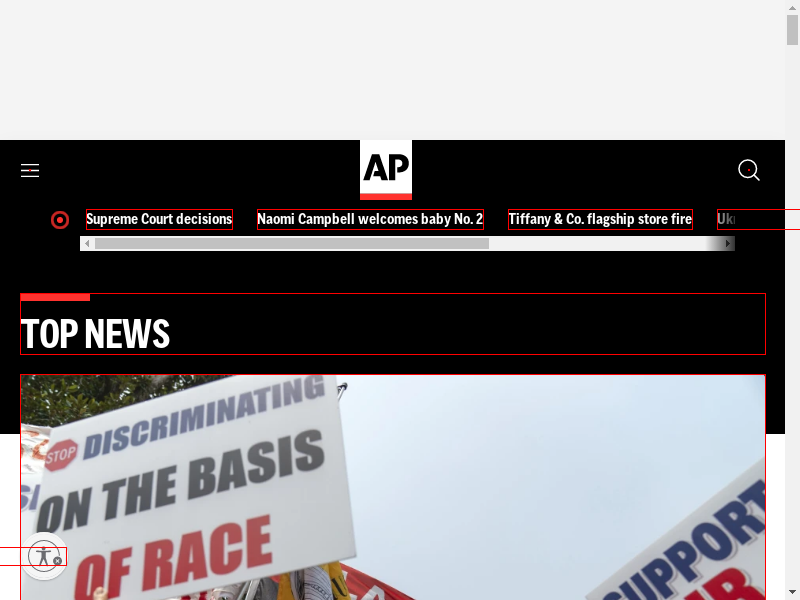

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,-134.0,547.000000,547.000000,565.000000,-134.0,66.0,200.0,18.00000,NaN,NaN,NaN,NaN,NaN
1,1,29.0,169.500000,169.500000,170.500000,29.0,30.0,1.0,1.00000,NaN,NaN,NaN,NaN,NaN
2,2,748.5,169.500000,169.500000,170.500000,748.5,749.5,1.0,1.00000,NaN,NaN,NaN,NaN,NaN
3,3,-57.0,328.000000,328.000000,352.000000,-57.0,-35.0,22.0,24.00000,NaN,NaN,NaN,More,NaN
4,4,-57.0,372.000000,372.000000,396.000000,-57.0,-35.0,22.0,24.00000,NaN,NaN,NaN,More,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,374,402.5,18887.984375,18887.984375,18907.203125,402.5,735.0,332.5,19.21875,NaN,NaN,NaN,NaN,NaN
375,375,50.0,18962.203125,18962.203125,18979.203125,50.0,356.0,306.0,17.00000,NaN,NaN,NaN,NaN,NaN
376,376,660.0,18961.203125,18961.203125,18962.203125,660.0,661.0,1.0,1.00000,NaN,NaN,NaN,NaN,NaN
377,377,697.0,18961.203125,18961.203125,18962.203125,697.0,698.0,1.0,1.00000,NaN,NaN,NaN,NaN,NaN


In [ ]:
# here we are missing the menu and search icon
describe("https___apnews_com_")

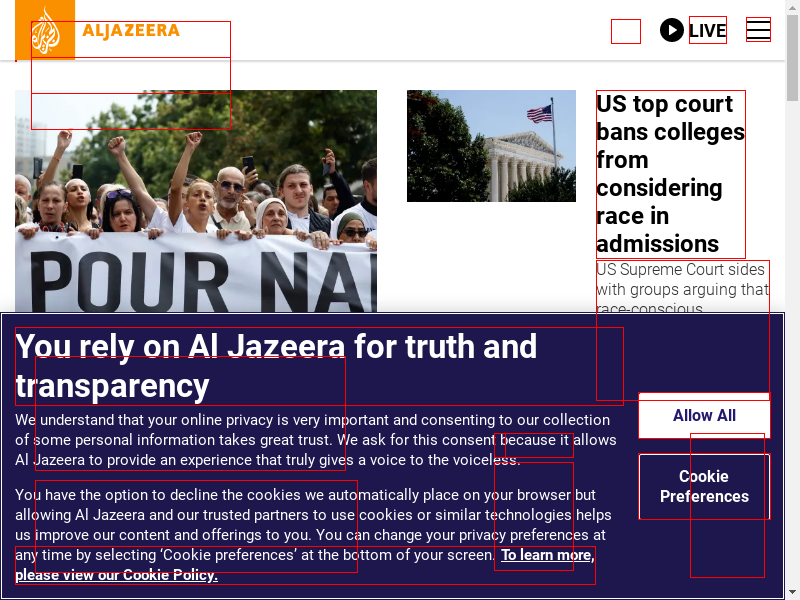

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,31.00000,21.000000,21.000000,22.000000,31.00000,32.00000,1.00000,1.0,NaN,NaN,NaN,NaN,NaN
1,1,31.00000,21.000000,21.000000,57.000000,31.00000,230.00000,199.00000,36.0,NaN,NaN,NaN,NaN,NaN
2,2,31.00000,57.000000,57.000000,93.000000,31.00000,230.00000,199.00000,36.0,NaN,NaN,NaN,NaN,NaN
3,3,31.00000,93.000000,93.000000,129.000000,31.00000,230.00000,199.00000,36.0,NaN,NaN,NaN,NaN,NaN
4,4,15.00000,60.000000,60.000000,61.000000,15.00000,16.00000,1.00000,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,116,596.84375,3628.515625,3628.515625,3668.515625,596.84375,763.84375,167.00000,40.0,NaN,NaN,NaN,NaN,NaN
117,117,15.00000,327.000000,327.000000,405.000000,15.00000,623.78125,608.78125,78.0,NaN,NaN,NaN,NaN,NaN
118,118,15.00000,546.000000,546.000000,584.000000,15.00000,595.00000,580.00000,38.0,NaN,NaN,NaN,More information about your privacy,NaN
119,119,638.78125,453.500000,453.500000,519.500000,638.78125,770.00000,131.21875,66.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# something with the boxes not right
describe("https___www_aljazeera_com_")

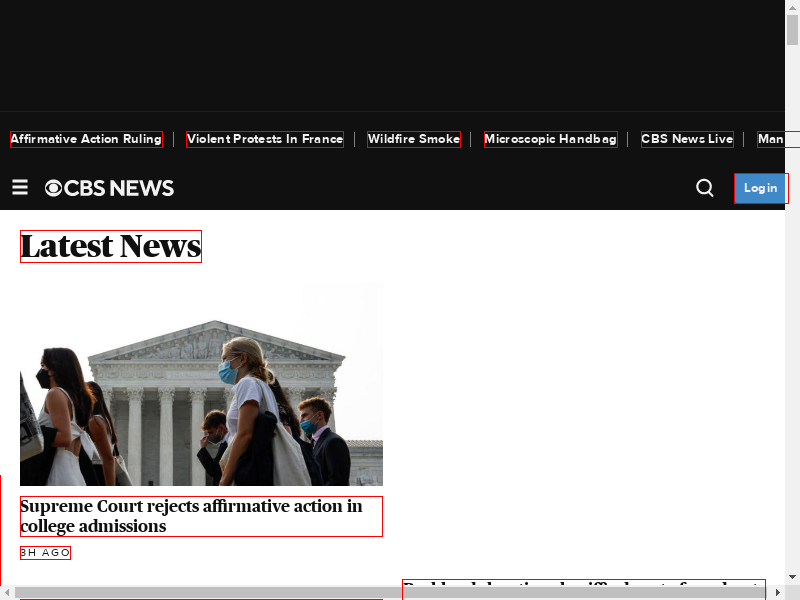

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,10.000000,131.000000,131.000000,147.000000,10.000000,162.500000,152.500000,16.0,NaN,NaN,NaN,NaN,NaN
1,1,186.812500,131.000000,131.000000,147.000000,186.812500,343.625000,156.812500,16.0,NaN,NaN,NaN,NaN,NaN
2,2,367.937500,131.000000,131.000000,147.000000,367.937500,460.140625,92.203125,16.0,NaN,NaN,NaN,NaN,NaN
3,3,484.453125,131.000000,131.000000,147.000000,484.453125,617.156250,132.703125,16.0,NaN,NaN,NaN,NaN,NaN
4,4,641.468750,131.000000,131.000000,147.000000,641.468750,733.375000,91.906250,16.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,384,455.000000,15163.453125,15163.453125,15203.453125,455.000000,495.000000,40.000000,40.0,NaN,NaN,youtube,Follow us on youtube,NaN
385,385,115.000000,-203.000000,-203.000000,-175.000000,115.000000,418.000000,303.000000,28.0,NaN,NaN,NaN,NaN,NaN
386,386,115.000000,-166.000000,-166.000000,-128.000000,115.000000,418.000000,303.000000,38.0,NaN,NaN,NaN,NaN,NaN
387,387,115.000000,-106.000000,-106.000000,-57.000000,115.000000,180.109375,65.109375,49.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# we are missing the menu
describe("https___www_cbsnews_com_")

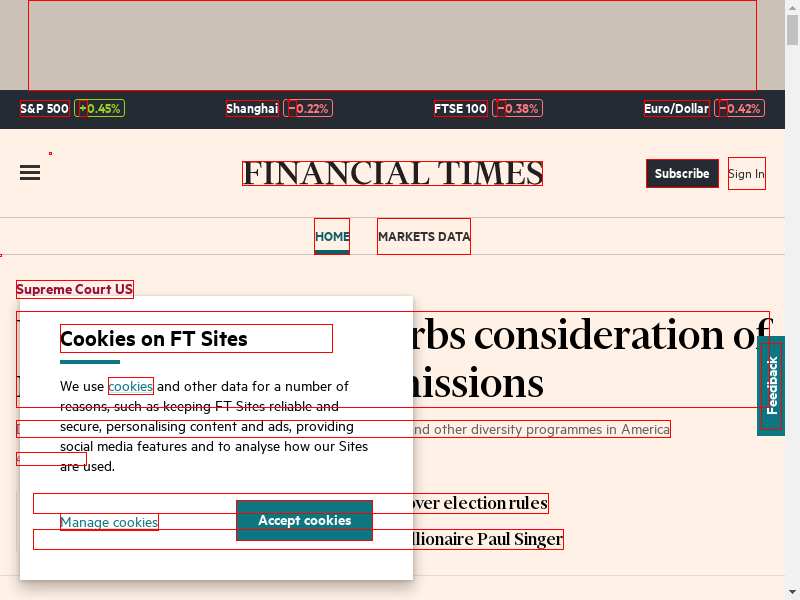

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,-9999.0,16.00000,16.00000,50.00000,-9999.0,-9845.171875,153.828125,34,NaN,NaN,NaN,NaN,NaN
1,1,-9999.0,16.00000,16.00000,50.00000,-9999.0,-9840.687500,158.312500,34,NaN,NaN,NaN,NaN,NaN
2,2,-9999.0,16.00000,16.00000,50.00000,-9999.0,-9861.156250,137.843750,34,NaN,NaN,NaN,NaN,NaN
3,3,-9999.0,16.00000,16.00000,50.00000,-9999.0,-9872.718750,126.281250,34,NaN,NaN,NaN,NaN,NaN
4,4,28.5,0.00000,0.00000,90.00000,28.5,756.500000,728.000000,90,NaN,NaN,3rd party ad content,Advertisement,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,300,275.0,17861.09375,17861.09375,17881.09375,275.0,510.000000,235.000000,20,NaN,NaN,NaN,NaN,NaN
301,301,275.0,17897.09375,17897.09375,17917.09375,275.0,510.000000,235.000000,20,NaN,NaN,NaN,NaN,NaN
302,302,530.0,17717.09375,17717.09375,17735.09375,530.0,684.000000,154.000000,18,NaN,NaN,NaN,NaN,NaN
303,303,433.0,18072.09375,18072.09375,18087.09375,433.0,446.000000,13.000000,15,NaN,NaN,Financial Times,F T,NaN


In [ ]:
# the scaner see the text behind the cookie popup, can we prevent him?
# also, why we don't find the cookie text box?
describe("https___www_ft_com_")

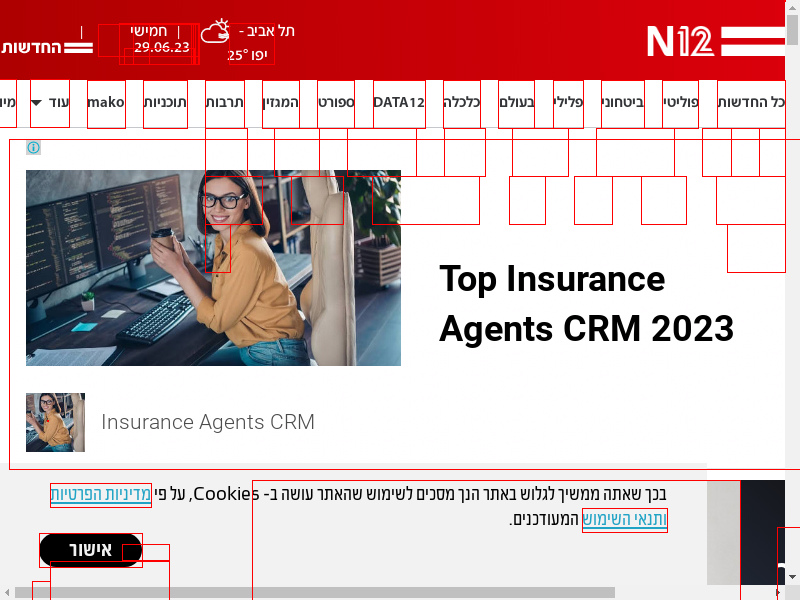

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,47.500000,420.0000,420.0000,420.700012,47.500000,48.200001,0.700001,0.700012,NaN,NaN,NaN,NaN,NaN
1,1,366.031250,-287.0000,-287.0000,-263.000000,366.031250,428.421875,62.390625,24.000000,NaN,NaN,NaN,NaN,NaN
2,2,196.000000,-291.0000,-291.0000,-290.000000,196.000000,197.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
3,3,298.000000,-287.0000,-287.0000,-263.000000,298.000000,360.390625,62.390625,24.000000,NaN,NaN,NaN,NaN,NaN
4,4,372.687500,-287.0000,-287.0000,-263.000000,372.687500,435.078125,62.390625,24.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,756,257.250000,10974.5625,10974.5625,10986.562500,257.250000,318.562500,61.312500,12.000000,NaN,NaN,NaN,NaN,NaN
757,757,254.953125,10999.5625,10999.5625,11011.562500,254.953125,318.562500,63.609375,12.000000,NaN,NaN,NaN,NaN,NaN
758,758,50.250000,483.0000,483.0000,507.000000,50.250000,151.250000,101.000000,24.000000,NaN,NaN,NaN,NaN,NaN
759,759,582.250000,508.0000,508.0000,532.000000,582.250000,667.250000,85.000000,24.000000,NaN,NaN,NaN,NaN,NaN


In [ ]:
# what are those boxes in the ad
describe("https___www_n12_co_il_")

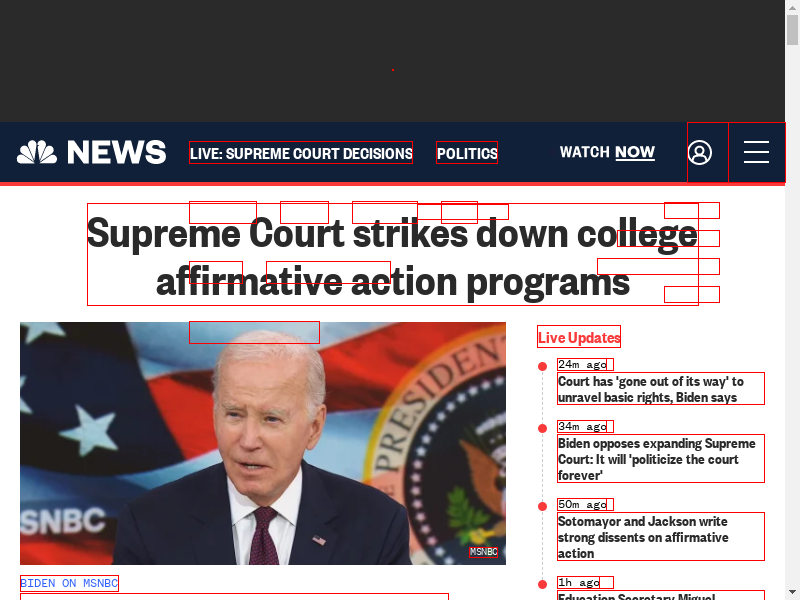

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,392.000000,69.5000,69.5000,70.5000,392.000000,393.000000,1.0,1.0,NaN,NaN,3rd party ad content,Advertisement,NaN
1,1,292.500000,-368.0000,-368.0000,-328.0000,292.500000,492.500000,200.0,40.0,NaN,NaN,NaN,NaN,NaN
2,2,189.796875,141.0000,141.0000,163.0000,189.796875,412.796875,223.0,22.0,NaN,NaN,NaN,NaN,NaN
3,3,436.796875,141.0000,141.0000,163.0000,436.796875,497.796875,61.0,22.0,NaN,NaN,NaN,NaN,NaN
4,4,189.796875,201.0000,201.0000,223.0000,189.796875,256.796875,67.0,22.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,403,272.000000,12029.9375,12029.9375,12045.9375,272.000000,376.000000,104.0,16.0,NaN,NaN,NaN,NaN,NaN
404,404,272.000000,12061.9375,12061.9375,12077.9375,272.000000,330.500000,58.5,16.0,NaN,NaN,NaN,NaN,NaN
405,405,272.000000,12093.9375,12093.9375,12109.9375,272.000000,369.500000,97.5,16.0,NaN,NaN,NaN,NaN,NaN
406,406,272.000000,12125.9375,12125.9375,12141.9375,272.000000,421.500000,149.5,16.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# again, boxs behind the ad
describe("https___www_nbcnews_com_")

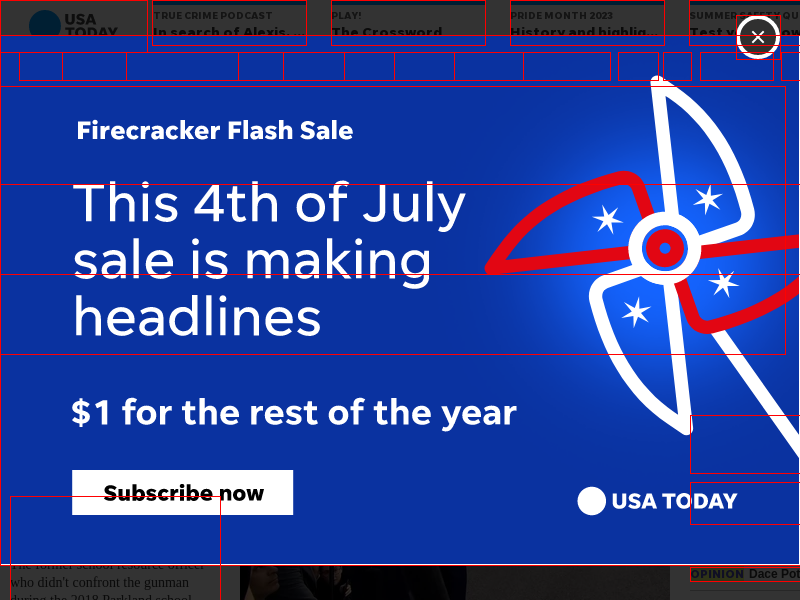

,Unnamed: 0,X,Y,Top,Bottom,Left,Right,Width,Height,ElementType,textContent,TooltipValue,AriaLabel,data-initial-value
0,0,0.00000,0.000000,0.000000,52.000000,0.00000,147.140625,147.140625,52.0,NaN,NaN,NaN,USA TODAY,NaN
1,1,152.50000,0.000000,0.000000,45.000000,152.50000,306.734375,154.234375,45.0,NaN,NaN,NaN,NaN,NaN
2,2,331.40625,0.000000,0.000000,45.000000,331.40625,485.640625,154.234375,45.0,NaN,NaN,NaN,NaN,NaN
3,3,510.31250,0.000000,0.000000,45.000000,510.31250,664.546875,154.234375,45.0,NaN,NaN,NaN,NaN,NaN
4,4,689.21875,0.000000,0.000000,45.000000,689.21875,843.453125,154.234375,45.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,215,10.00000,8179.640625,8179.640625,8287.640625,10.00000,890.000000,880.000000,108.0,NaN,NaN,NaN,advertisement,NaN
216,216,86.00000,8197.640625,8197.640625,8287.640625,86.00000,814.000000,728.000000,90.0,NaN,NaN,3rd party ad content,Advertisement,NaN
217,217,10.00000,8333.640625,8333.640625,9015.640625,10.00000,890.000000,880.000000,682.0,NaN,NaN,NaN,NaN,NaN
218,218,736.00000,15.000000,15.000000,59.000000,736.00000,780.000000,44.000000,44.0,NaN,NaN,NaN,Close Special Offer,NaN


In [ ]:
# one big ad
describe("https___www_usatoday_com_")